Problem Background:


*   We will try to predict how much money we should budget for sales commissions of 500 sales officer for the next year.
*   We likely have some experience with prior years’ commissions payments. This distribution looks like a normal distribution with a mean of 100% and standard deviation of 10%.

Source: https://pbpython.com/monte-carlo.html 


In [1]:
import pandas as pd # to construct a model that replicates the Excel spreadsheet calculation
import numpy as np # a random number generation
import seaborn as sns # plotting the result

sns.set_style('whitegrid')

In [3]:
avg = 1
std_dev = .1
num_sales_officer = 500
num_simulations = 1000

In [4]:
# Now we can use numpy to generate a list of percentages that will replicate our historical normal distribution:
pct_to_target = np.random.normal(avg, std_dev, num_sales_officer).round(2) # round(2) --> bulatkan menjadi 2 desimal

In [ ]:
pct_to_target # display



*  There is one other value that we need to simulate and that is the actual sales target.
*  The data distribution shows us that prior sales targets are set into 1 of 6 buckets and the frequency gets lower as the amount increases. 
*   We will use a **uniform distribution** but assign lower probability rates for some of the values.





In [10]:
sales_target_values = [75_000, 100_000, 200_000, 300_000, 400_000, 500_000]
sales_target_prob = [.3, .3, .2, .1, .05, .05]
sales_target = np.random.choice(sales_target_values, num_sales_officer, p=sales_target_prob)

In [ ]:
sales_target # display

Now that we know how to create our two input distributions, let’s build up a pandas dataframe:

In [12]:
df = pd.DataFrame(index=range(num_sales_officer), data={'Pct_To_Target': pct_to_target,
                                               'Sales_Target': sales_target})

df['Sales'] = df['Pct_To_Target'] * df['Sales_Target']

In [13]:
df # display the data frame

,Pct_To_Target,Sales_Target,Sales
0,0.97,200000,194000.0
1,0.88,300000,264000.0
2,0.99,500000,495000.0
3,1.06,75000,79500.0
4,0.99,100000,99000.0
...,...,...,...
495,1.06,75000,79500.0
496,1.08,200000,216000.0
497,1.11,200000,222000.0
498,0.95,300000,285000.0


The final piece of code we need to create is a way to map our Pct_To_Target to the commission rate. Here is the function:

In [14]:
def calc_commission_rate(x):
    """ Return the commission rate based on the table:
    0-90% = 2%
    91-99% = 3%
    >= 100 = 4%
    """
    if x <= .90:
        return .02
    if x <= .99:
        return .03
    else:
        return .04

Now we create our commission rate and multiply it by sales:

In [15]:
df['Commission_Rate'] = df['Pct_To_Target'].apply(calc_commission_rate)
df['Commission_Amount'] = df['Commission_Rate'] * df['Sales']

In [16]:
df # display

,Pct_To_Target,Sales_Target,Sales,Commission_Rate,Commission_Amount
0,0.97,200000,194000.0,0.03,5820.0
1,0.88,300000,264000.0,0.02,5280.0
2,0.99,500000,495000.0,0.03,14850.0
3,1.06,75000,79500.0,0.04,3180.0
4,0.99,100000,99000.0,0.03,2970.0
...,...,...,...,...,...
495,1.06,75000,79500.0,0.04,3180.0
496,1.08,200000,216000.0,0.04,8640.0
497,1.11,200000,222000.0,0.04,8880.0
498,0.95,300000,285000.0,0.03,8550.0


The real “magic” of the Monte Carlo simulation is that if we run a simulation many times, we start to develop a picture of the likely distribution of results.

In python, we can use a **for loop** to run as many simulations as we’d like.

In [17]:
# Define a list to keep all the results from each simulation that we want to analyze
all_stats = []

# Loop through many simulations
for i in range(num_simulations):

    # Choose random inputs for the sales targets and percent to target
    sales_target = np.random.choice(sales_target_values, num_sales_officer, p=sales_target_prob)
    pct_to_target = np.random.normal(avg, std_dev, num_sales_officer).round(2)

    # Build the dataframe based on the inputs and number of reps
    df = pd.DataFrame(index=range(num_sales_officer), data={'Pct_To_Target': pct_to_target,
                                                   'Sales_Target': sales_target})

    # Back into the sales number using the percent to target rate
    df['Sales'] = df['Pct_To_Target'] * df['Sales_Target']

    # Determine the commissions rate and calculate it
    df['Commission_Rate'] = df['Pct_To_Target'].apply(calc_commission_rate)
    df['Commission_Amount'] = df['Commission_Rate'] * df['Sales']

    # We want to track sales,commission amounts and sales targets over all the simulations
    all_stats.append([df['Sales'].sum().round(0),
                      df['Commission_Amount'].sum().round(0),
                      df['Sales_Target'].sum().round(0)])

In [ ]:
all_stats # display

In [19]:
results_df = pd.DataFrame.from_records(all_stats, columns=['Sales',
                                                           'Commission_Amount',
                                                           'Sales_Target'])

In [20]:
results_df.describe().style.format('{:,}')

,Sales,Commission_Amount,Sales_Target
count,"1,000.0","1,000.0","1,000.0"
mean,"83,892,656.0","2,864,360.126","83,888,950.0"
std,"2,740,024.990257614","101,583.66331529239","2,731,367.929860104"
min,"74,748,000.0","2,541,340.0","74,550,000.0"
25%,"81,859,937.5","2,791,594.25","81,918,750.0"
50%,"83,774,000.0","2,859,184.0","83,787,500.0"
75%,"85,717,062.5","2,937,517.25","85,731,250.0"
max,"93,517,750.0","3,182,385.0","93,475,000.0"


We can see that the average commissions amount expense is 2.86M and the standard deviation is 102K. We can also see that the commissions payment can be as low as 2.5M or as high as 3.2M.

Based on these results, we can estimate that the sales comission budget for the next year is around USD 2.86M

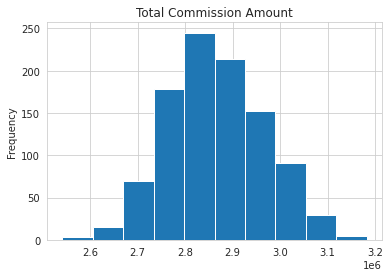

In [30]:
results_df['Commission_Amount'].plot(kind='hist', title="Total Commission Amount") # result plotting